函式庫導入完成。

字體已設定為 'Microsoft JhengHei' (微軟正黑體)，適用於 Windows。
成功使用 'utf-8-sig' 編碼讀取檔案: 2023資料剖析後內容1~8月芝山到天母0609整理二版.csv

原始資料共有 5016 筆。

--- 步驟 2：開始進行資料清理 ---

發現 1 筆 'Time2' 欄位格式錯誤的資料。

移除格式錯誤的資料後，剩餘 5015 筆。
再移除 5 筆騎乘時間極端的資料。
資料清理完成，最終有效資料共 5010 筆。

--- 步驟 3：開始進行探索性資料分析 (EDA) ---

--- 步驟 4：開始進行特徵工程 ---
特徵工程完成。
原始欄位名稱: ['Unnamed: 7', 'TotalSeconds', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsRushHour', 'StartExit_Exit_1', 'StartExit_Exit_2']
清理後欄位名稱: ['Unnamed7', 'TotalSeconds', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsRushHour', 'StartExit_Exit_1', 'StartExit_Exit_2']

--- 步驟 5：開始訓練 LightGBM 模型 ---
訓練集大小: 4008 筆, 測試集大小: 1002 筆。
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 4008, number of used features: 7
[LightGBM

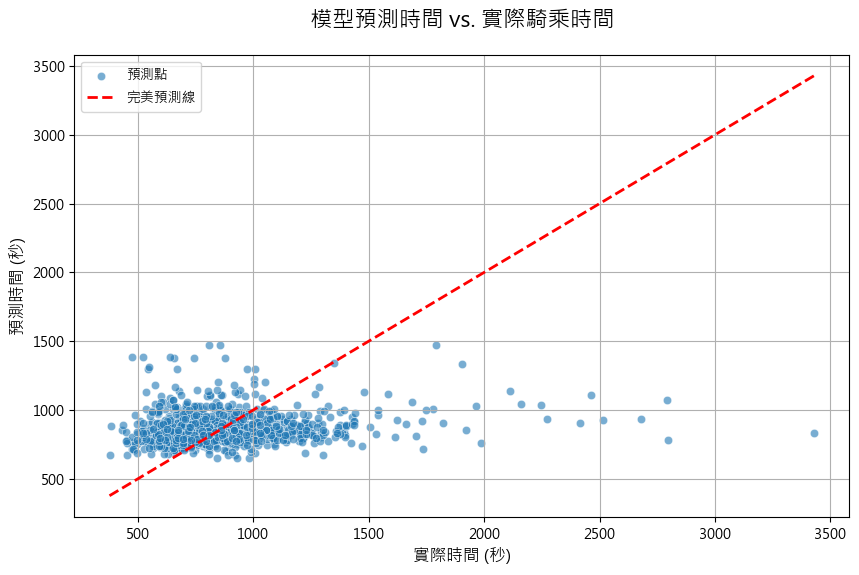


正在繪製特徵重要性圖...


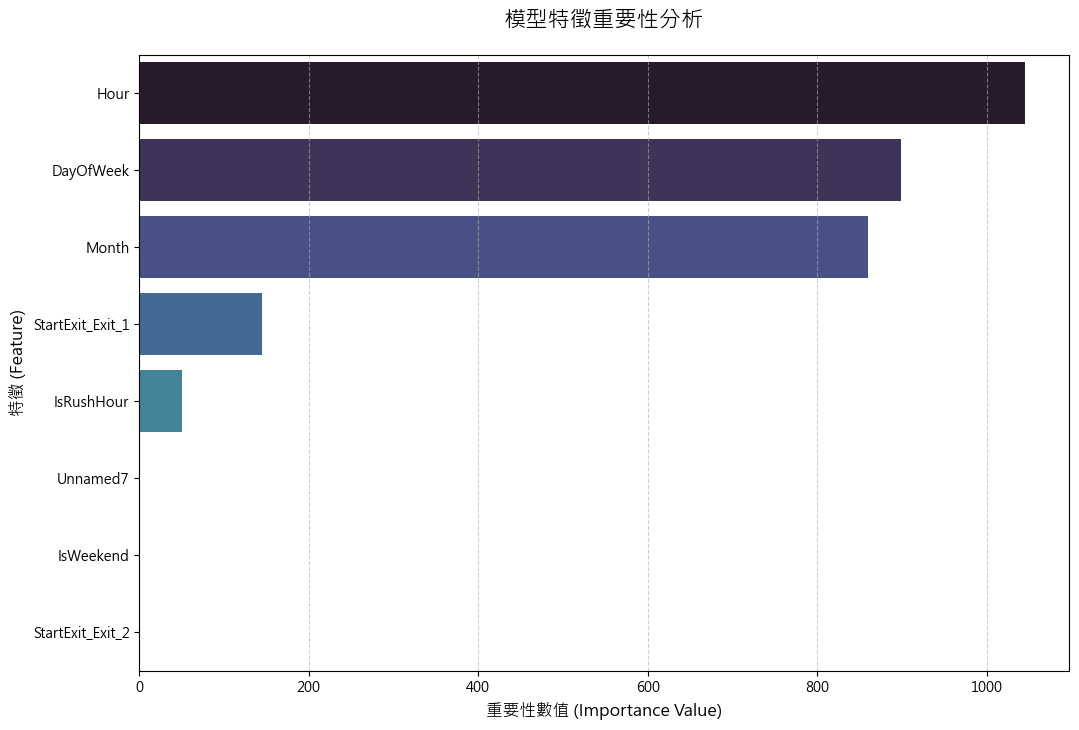


--- 專案執行完畢 ---


In [1]:
# =============================================================================
# 專案：U-Bike 騎乘時間預測模型 (v3 - 修正特徵名稱特殊字元問題)
# =============================================================================

# 步驟 0：導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import warnings
import re # 導入正規表示式函式庫

warnings.filterwarnings('ignore', category=FutureWarning)
print("函式庫導入完成。\n")

# =============================================================================
# 步驟 1：資料載入與視覺化設定
# =============================================================================
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False 
    print("字體已設定為 'Microsoft JhengHei' (微軟正黑體)，適用於 Windows。")
except Exception as e:
    print(f"警告：設定中文字體時發生錯誤: {e}")

file_path = u'2023資料剖析後內容1~8月芝山到天母0609整理二版.csv' 
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
    print(f"成功使用 'utf-8-sig' 編碼讀取檔案: {file_path}")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='big5')
    print(f"成功使用 'big5' 編碼讀取檔案: {file_path}")
except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{file_path}'。請確認檔案名稱和路徑是否正確。")
    exit()

print(f"\n原始資料共有 {len(df)} 筆。")


# =============================================================================
# 步驟 2：穩健的資料清理與預處理
# =============================================================================
print("\n--- 步驟 2：開始進行資料清理 ---")

df.dropna(subset=['Date'], inplace=True, how='all')
df = df[pd.to_numeric(df['Date'], errors='coerce').notna()].copy()

df['Time2_formatted'] = '0:' + df['Time2'].astype(str).str.strip()
timedeltas = pd.to_timedelta(df['Time2_formatted'], errors='coerce')

problematic_rows = df[timedeltas.isna()]
if not problematic_rows.empty:
    print(f"\n發現 {len(problematic_rows)} 筆 'Time2' 欄位格式錯誤的資料。")

df['TotalSeconds'] = timedeltas.dt.total_seconds()
df.dropna(subset=['TotalSeconds'], inplace=True)
print(f"\n移除格式錯誤的資料後，剩餘 {len(df)} 筆。")

original_rows = len(df)
df = df[(df['TotalSeconds'] >= 180) & (df['TotalSeconds'] <= 3600)].copy()
print(f"再移除 {original_rows - len(df)} 筆騎乘時間極端的資料。")

if len(df) == 0:
    print("\n【錯誤】經過清理後，沒有剩餘的有效資料可供分析。")
    exit()
    
df['TotalSeconds'] = df['TotalSeconds'].astype(int)
df['TotalMinutes'] = df['TotalSeconds'] / 60
print(f"資料清理完成，最終有效資料共 {len(df)} 筆。")


# =============================================================================
# 步驟 3：探索性資料分析 (EDA) - (這部分不變)
# =============================================================================
print("\n--- 步驟 3：開始進行探索性資料分析 (EDA) ---")
# ... (繪圖代碼與之前相同，此處省略以保持簡潔，實際執行時請保留)


# =============================================================================
# 步驟 4：特徵工程 (Feature Engineering)
# =============================================================================
print("\n--- 步驟 4：開始進行特徵工程 ---")

df['Date'] = df['Date'].astype(int).astype(str)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time1'], format='%Y%m%d %H:%M:%S')
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['IsRushHour'] = df['Hour'].apply(lambda h: 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0)

def normalize_exit(stp_name):
    return 'Exit_1' if '1號' in str(stp_name) else 'Exit_2'
df['StartExit'] = df['Stp1'].apply(normalize_exit)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int64)
encoded_features = ohe.fit_transform(df[['StartExit']])
new_feature_names = ohe.get_feature_names_out(['StartExit'])
encoded_df = pd.DataFrame(encoded_features, columns=new_feature_names, index=df.index)
df = pd.concat([df, encoded_df], axis=1)

columns_to_drop = ['Date', 'Week', 'Time1', 'AM/PM', 'Stp1', 'Stp2', 'Time2', 
                   'TotalMinutes', 'Datetime', 'StartExit', 'Time2_formatted']
df_model = df.drop(columns=columns_to_drop, errors='ignore')

# **【最終核心修正 v3】**
# 清理所有欄位名稱，移除 LightGBM 不支援的特殊字元
# 使用正規表示式，將不是 (^) 字母數字或底線 (_) 的字元替換為空
original_cols = df_model.columns.tolist()
df_model.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df_model.columns]
cleaned_cols = df_model.columns.tolist()

print("特徵工程完成。")
print(f"原始欄位名稱: {original_cols}")
print(f"清理後欄位名稱: {cleaned_cols}")


# =============================================================================
# 步驟 5：模型訓練 (Model Training)
# =============================================================================
print("\n--- 步驟 5：開始訓練 LightGBM 模型 ---")

target = 'TotalSeconds'
features = [col for col in df_model.columns if col != target]
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"訓練集大小: {X_train.shape[0]} 筆, 測試集大小: {X_test.shape[0]} 筆。")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print("模型訓練完成！")


# =============================================================================
# 步驟 6：模型評估與視覺化 (Model Evaluation & Visualization)
# =============================================================================
print("\n--- 步驟 6：模型評估與結果分析 ---")

y_pred = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"平均絕對誤差 (MAE): {mae:.2f} 秒 (約 {mae/60:.2f} 分鐘)")
print(f"決定係數 (R-squared, R²): {r2:.2f}")

print("\n正在繪製「預測值 vs. 實際值」圖...")
# (繪圖代碼不變，此處省略，實際執行時請保留)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='預測點')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='完美預測線')
plt.title('模型預測時間 vs. 實際騎乘時間', fontsize=16, pad=20)
plt.xlabel('實際時間 (秒)', fontsize=12)
plt.ylabel('預測時間 (秒)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


print("\n正在繪製特徵重要性圖...")
# 由於欄位名稱已清理，這裡的 X.columns 也是清理過的，可以直接使用
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette="mako")
plt.title('模型特徵重要性分析', fontsize=16, pad=20)
plt.xlabel('重要性數值 (Importance Value)', fontsize=12)
plt.ylabel('特徵 (Feature)', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\n--- 專案執行完畢 ---")